# Classifieur - Filtre de Butterworth

## Import des librairies

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing
from tools.data import get_datasets

## Import des données

In [2]:
train, test = get_datasets()

Reading data file


## Entropie du signal

In [3]:
def entropy(signal):
    lensig=signal.size
    symset=list(set(signal))
    numsym=len(symset)
    propab=[np.size(signal[signal==i])/(1.0*lensig) for i in symset]
    ent=np.sum([p*np.log2(1.0/p) for p in propab])
    return ent

## Filtre de Butterworth

In [4]:
# Fonction permettant d'afficher les graphiques des signaux filtrés à l'aide d'un filtre de Butterworth

def butterworth_plot(dataset, n):
    Wn = [('lowpass', 0.035) , ('bandpass', (0.035,0.07)) , ('bandpass', (0.07, 0.113)), ('bandpass', (0.113, 0.26)), ('highpass', 0.26)]
    butter = np.zeros((dataset.shape[0], 12))
    #length = dataset[n,0]
    length = 400
    current = []
    plt.figure(figsize=(15, 10))
    plt.title('Donnees brutes')
    plt.plot(dataset[n, 1:1+length])
    plt.plot(dataset[n, 1+512:1+512+length])
    plt.plot(dataset[n, 1+512*2:1+512*2+length])
    plt.plot(dataset[n, 1+512*3:1+512*3+length])
    for filter_type, value in Wn :
        b, a = signal.butter(5, value, filter_type)
        plt.figure(figsize=(15, 10))
        plt.title('Donnees filtre butterworth (%s , %s)' % (filter_type, value))
        plt.plot(signal.filtfilt(b, a, dataset[n, 1:1+length]))
        plt.plot(signal.filtfilt(b, a, dataset[n, 1+512:1+512+length]))
        plt.plot(signal.filtfilt(b, a, dataset[n, 1+512*2:1+512*2+length]))
        plt.plot(signal.filtfilt(b, a, dataset[n, 1+512*3:1+512*3+length]))
        plt.show()

In [5]:
# Fonction permettant d'extraire la puissance et l'écart-type des signaux issus du filtre du Butterworth
def butterworth_filter(dataset):
    Wn = [('lowpass', 0.00035)]
#   Wn = [('lowpass', 0.035), ('bandpass', (0.035,0.07)) , ('bandpass', (0.07, 0.113)), ('bandpass', (0.113, 0.26)), ('highpass', 0.26)]
    butter = np.zeros((dataset.shape[0], 4))
    for i in range(dataset.shape[0]) :
        #length = dataset[i,0]
        length = 400
        current = []
        for filter_type, value in Wn :
            b, a = signal.butter(1, value, filter_type)
            sig_filtered = signal.filtfilt(b, a, dataset[i, 1:1+length])
            current.append((np.sum(sig_filtered)**2)/length)
            #current.append((np.std(sig_filtered))/length)
            #current.append((entropy(sig_filtered))/length)
            sig_filtered = signal.filtfilt(b, a, dataset[i, 1+512:1+512+length])
            current.append((np.sum(sig_filtered)**2)/length)
            #current.append((np.std(sig_filtered))/length)
            #current.append((entropy(sig_filtered))/length)
            sig_filtered = signal.filtfilt(b, a, dataset[i, 1+512*2:1+512*2+length])
            current.append((np.sum(sig_filtered)**2)/length)
            #current.append((np.std(sig_filtered))/length)
            #current.append((entropy(sig_filtered))/length)
            sig_filtered = signal.filtfilt(b, a, dataset[i, 1+512*3:1+512*3+length])
            current.append((np.sum(sig_filtered)**2)/length)
            #current.append((np.std(sig_filtered))/length)
            #current.append((entropy(sig_filtered))/length)
        butter[i] = np.array(current)
    return butter

## Classification multiclasse

In [6]:
# Préparation des données, on enlève la classe -1

train_mult = np.compress(train[:,-1] >= 0, train, axis=0)
test_mult = np.compress(test[:,-1] >= 0, test, axis=0)

In [7]:
# Classification multiclasse

train_std_mult = butterworth_filter(train_mult)
test_std_mult = butterworth_filter(test_mult)

In [8]:
# Normalisation

train_std_mult_norm = preprocessing.normalize(train_std_mult)
test_std_mult_norm = preprocessing.normalize(test_std_mult)

In [9]:
# Classifieur k-PPV pour différentes valeurs de k

for n in [10, 20, 30]:
    # train set
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(train_std_mult_norm, train_mult[:,-1])

    # test set
    total_correct = 0
    for i in range(test_std_mult_norm.shape[0]):
        if neigh.predict(test_std_mult_norm[i])[0] == test_mult[i,-1]:
            total_correct += 1

    print 'Pourcentage correct %d:' % n, float(total_correct) / test_std_mult_norm.shape[0] * 100

Pourcentage correct 10: 10.3936421209
Pourcentage correct 20: 10.2073761331
Pourcentage correct 30: 10.3936421209


#### Meilleur résultats :

Butterworth(puissance) + k-PPV --> k = 21 : 10.24%

Butterworth(puissance, ecart-type) + k-PPV --> k = 17 : 10.02%

Butterworth(filtre = lowpass 0.00035) + Puissance + K-PPV --> k = 10: 10.39%

In [10]:
# Classifieur SVM

# train set
classifier = svm.SVC(kernel='rbf')
classifier.fit(train_std_mult_norm, train_mult[:,-1])
# test set
total_correct = 0
for i in range(test_std_mult_norm.shape[0]):
    if classifier.predict(test_std_mult_norm[i])[0] == test_mult[i,-1]:
        total_correct += 1
print 'Pourcentage correct :' , float(total_correct) / test_std_mult_norm.shape[0] * 100

Pourcentage correct : 10.1949584006


#### Meilleur résultats :

Butterworth(puissance, ecart-type) + SVM (Kernel: Poly, Degree: 5) : 10.51%

Butterworth(filtre = lowpass 0.00035) + Puissance + SVM (kernel = rbf) --> 10.19%

## Classification Binaire

In [11]:
# Classification -1 vs >=0
# on prépare les données:
# tout ce qui est un chiffre -> 1
# tout ce qui est du bruit -> 0

train_bin = train.copy()
test_bin = test.copy()

train_bin[train_bin[:,-1] >= 0,-1] =  0
test_bin[test_bin[:,-1] >= 0,-1] =  0

train_bin[:,-1] = train_bin[:,-1] + 1
test_bin[:,-1] = test_bin[:,-1] + 1

In [12]:
# Classification binaire

train_std_bin = butterworth_filter(train_bin)
test_std_bin = butterworth_filter(test_bin)

In [13]:
# Normalisation

train_std_bin_norm = preprocessing.normalize(train_std_bin)
test_std_bin_norm = preprocessing.normalize(test_std_bin)

In [14]:
# Classifieur k-PPV pour différentes valeurs de k

for n in [10, 20, 30]:
    # train set
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(train_std_bin_norm, train_bin[:,-1])

    # test set
    total_correct = 0
    for i in range(test_std_bin_norm.shape[0]):
        if neigh.predict(test_std_bin_norm[i])[0] == test_bin[i,-1]:
            total_correct += 1

    print 'Pourcentage correct %d:' % n, float(total_correct) / test_std_bin_norm.shape[0] * 100

Pourcentage correct 10: 92.5066011108
Pourcentage correct 20: 92.5976509151
Pourcentage correct 30: 92.4974961304


#### Meilleur résultats :

Butterworth(puissance) + k-PPV --> k = 24: 87.65%

Butterworth(puissance, ecart-type) + k-PPV --> k = 14: 87.66%

Butterworth(filtre = lowpass 0.00035) + Puissance + K-PPV --> k = 20: 92.59%
# MEILLEUR RESULTAT : 92.59%

In [15]:
# Classifieur SVM

# train set
classifier = svm.SVC(kernel='rbf')
classifier.fit(train_std_bin_norm, train_bin[:,-1])
# test set
total_correct = 0
for i in range(test_std_bin_norm.shape[0]):
    if classifier.predict(test_std_bin_norm[i])[0] == test_bin[i,-1]:
        total_correct += 1
print 'Pourcentage correct :' , float(total_correct) / test_std_bin_norm.shape[0] * 100

Pourcentage correct : 86.4973140308


#### Meilleur résultats :

Butterworth(filtre = lowpass 0.00035) + Puissance + SVM (kernel = rbf) --> 86.49%

## Exemple d'affichage de données filtrées avec Butterworth

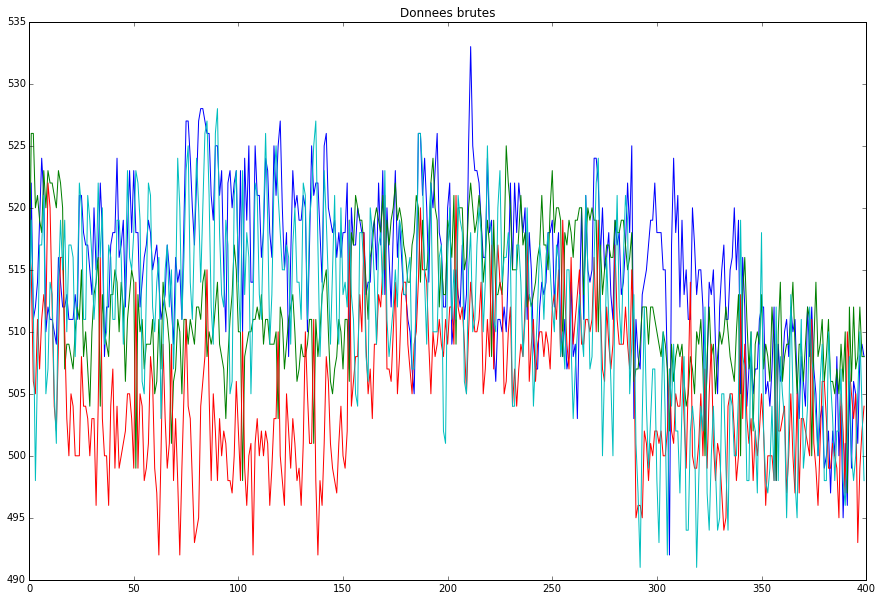

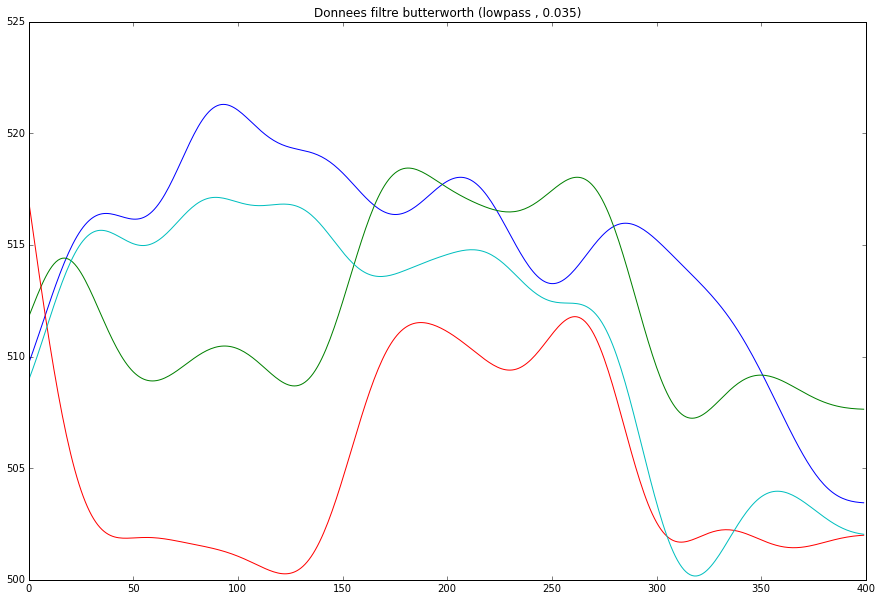

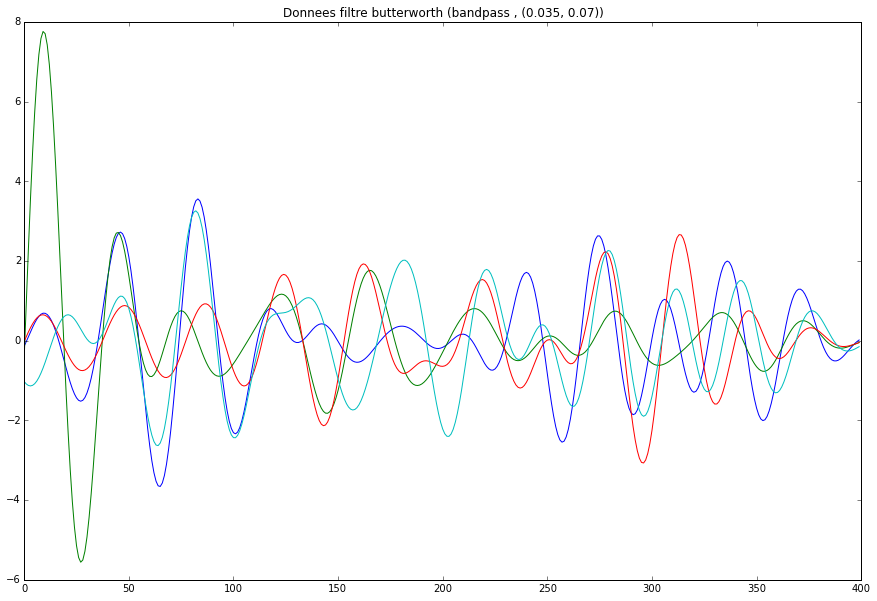

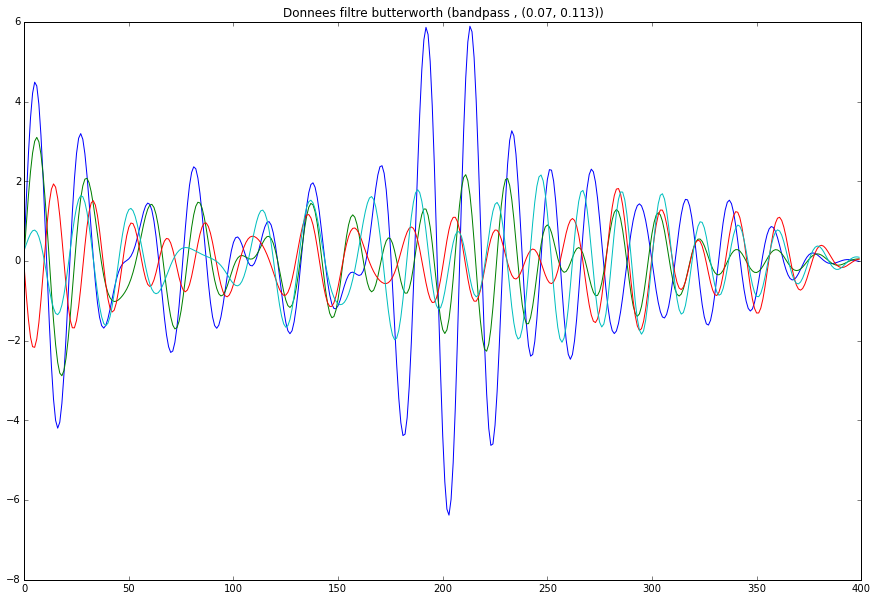

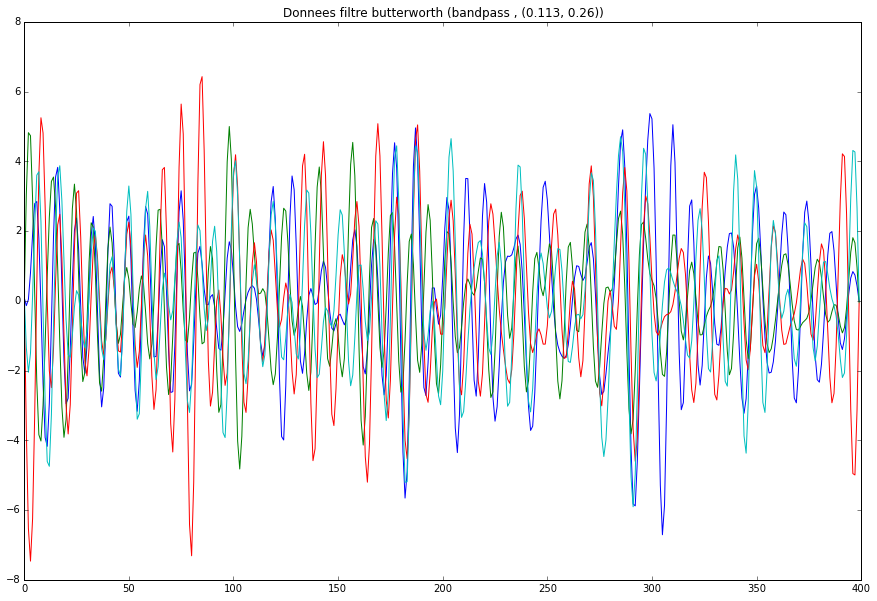

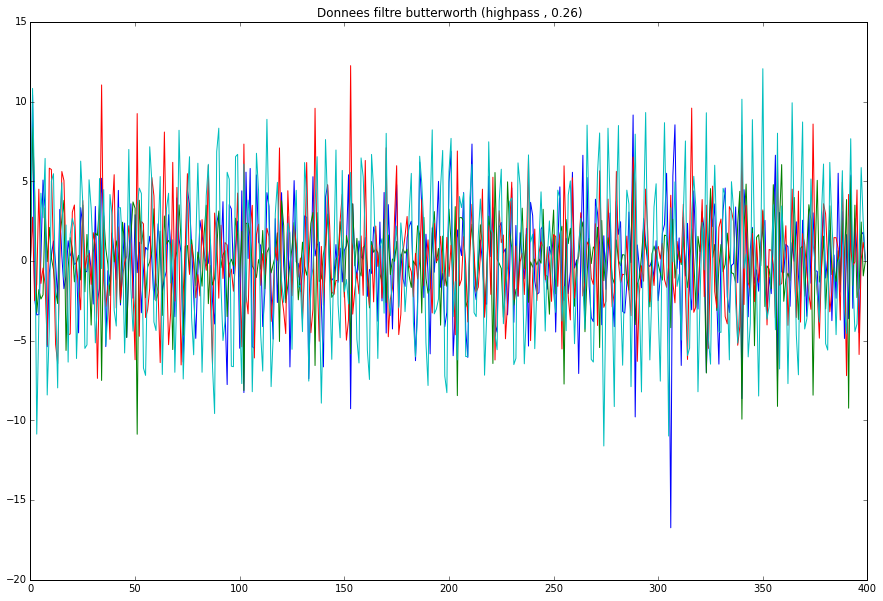

In [16]:
# Affichage des graphiques des signaux filtrés avec Butterworth, extrait 24
butterworth_plot(train, 24)